In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


from plotly.subplots import make_subplots
import plotly.graph_objs as go

/var/folders/20/0y46cgg97gs8kf_s9bthlzgm0000gn/T/ipykernel_66137/1093884970.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Most of the code is from my algorithm trading cw2

In [3]:
trading_data = pd.read_csv('Algorithmic_for_stock.csv')
trading_data

,Date,Predicted_LSTM,Real,Predicted_Transformer,Predicted_ARIMA,Predicted_Null
0,2023-03-30,266.84006,273.829987,274.829987,NaN,NaN
1,2023-03-31,267.25565,277.769989,278.769989,273.211053,273.829987
2,2023-04-03,269.62057,279.649994,280.649994,273.296469,277.769989
3,2023-04-04,278.11157,274.529999,275.529999,271.951366,279.649994
4,2023-04-05,275.16833,268.809998,269.667120,274.989228,274.529999
...,...,...,...,...,...,...
246,2024-03-22,875.04790,942.890015,946.300984,908.278300,914.349976
247,2024-03-25,878.84260,950.020020,953.480297,909.683920,942.890015
248,2024-03-26,886.68225,925.609985,929.124155,908.277743,950.020020
249,2024-03-27,896.78876,902.500000,906.050115,906.679578,925.609985


In [4]:
inital_capital = 500,000

In [5]:
# EWMA
def ewma(data, period):
    return data.ewm(span=period).mean()

ewma_df = trading_data.copy()
ewma_df['fast'] = ewma(trading_data['Real'], 50)
ewma_df['slow'] = ewma(trading_data['Real'], 90)

In [6]:
def get_signals(data: pd.DataFrame) -> pd.DataFrame:
    dataset = data.copy()
    dataset['signal'] = 0
    for i in range(1, len(dataset)):
        
        if dataset['fast'].iloc[i] < dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] > dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = -1
        
        elif dataset['fast'].iloc[i] > dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] < dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = 1
    return dataset

ewma_df = get_signals(ewma_df)
ewma_df.index = pd.to_datetime(ewma_df['Date'])

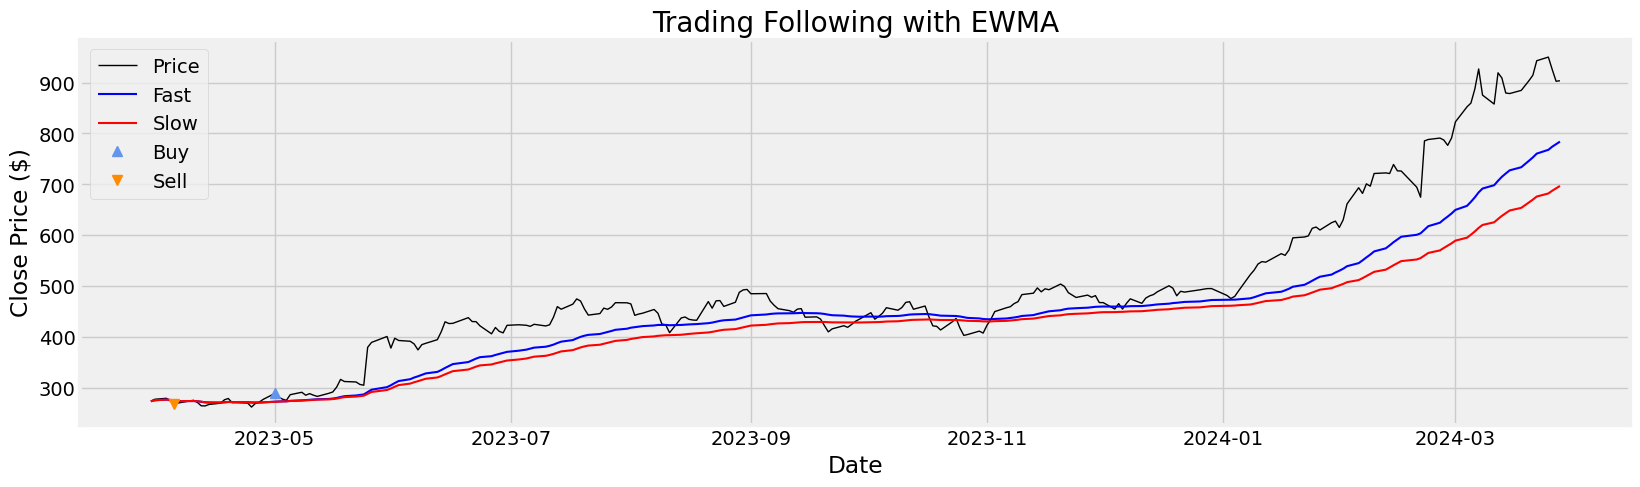

In [7]:
plt.figure(figsize=(20, 5))
plt.style.use('fivethirtyeight') 

plt.title('Trading Following with EWMA')

# Plot main price line
plt.plot(ewma_df.index, ewma_df['Real'], label='Price', color='black', linewidth=1)  # Thicker price lin

# Differentiate buy and sell signals with markers and colors
buy_signals = ewma_df[ewma_df['signal'] == 1].index
sell_signals = ewma_df[ewma_df['signal'] == -1].index

# Plot fast and slow EWMAs
plt.plot(ewma_df.index, ewma_df['fast'], label='Fast', color='blue', linewidth=1.5)  # Thinner EWMA lines
plt.plot(ewma_df.index, ewma_df['slow'], label='Slow', color='red', linewidth=1.5)

plt.plot(buy_signals, ewma_df['Real'][buy_signals], marker='^', linestyle='', color='cornflowerblue', label='Buy', markersize=7) 
plt.plot(sell_signals, ewma_df['Real'][sell_signals], marker='v', linestyle='', color='darkorange', label='Sell', markersize=7)

plt.xlabel(xlabel='Date')
plt.ylabel(ylabel='Close Price ($)')

plt.legend()
plt.show()

In [9]:
# MACD
macd_df = trading_data.copy()
twelve_day_ewma = ewma(macd_df['Real'], 12)
twenty_six_day_ewma = ewma(macd_df['Real'], 26)

macd = twelve_day_ewma - twenty_six_day_ewma
macd_signal = ewma(macd, 9)
macd_hist = macd - macd_signal

macd_df['12-ewma'] = twelve_day_ewma
macd_df['26-ewma'] = twenty_six_day_ewma
macd_df['MACD'] = macd
macd_df['MACD Signal'] = macd_signal
macd_df['MACD Hist'] = macd_hist

In [10]:
def find_signal(dataset):
    data = dataset.copy()
    data["signal"] = 0
    
    for i in range(1, len(data)):
        # we buy if the MACD line crosses above the signal line
        if data['MACD'].iloc[i] > data['MACD Signal'].iloc[i] and data['MACD'].iloc[i-1] < data['MACD Signal'].iloc[i-1]:
            data.loc[i, 'signal'] = 1
            
        # we sell if the MACD line crosses below the signal line
        elif data['MACD'].iloc[i] < data['MACD Signal'].iloc[i] and data['MACD'].iloc[i-1] > data['MACD Signal'].iloc[i-1]:
            data.loc[i, 'signal'] = -1
        else:
            data.loc[i, 'signal'] = 0
    return data

macd_df = find_signal(macd_df)
macd_df.index = pd.to_datetime(macd_df['Date'])

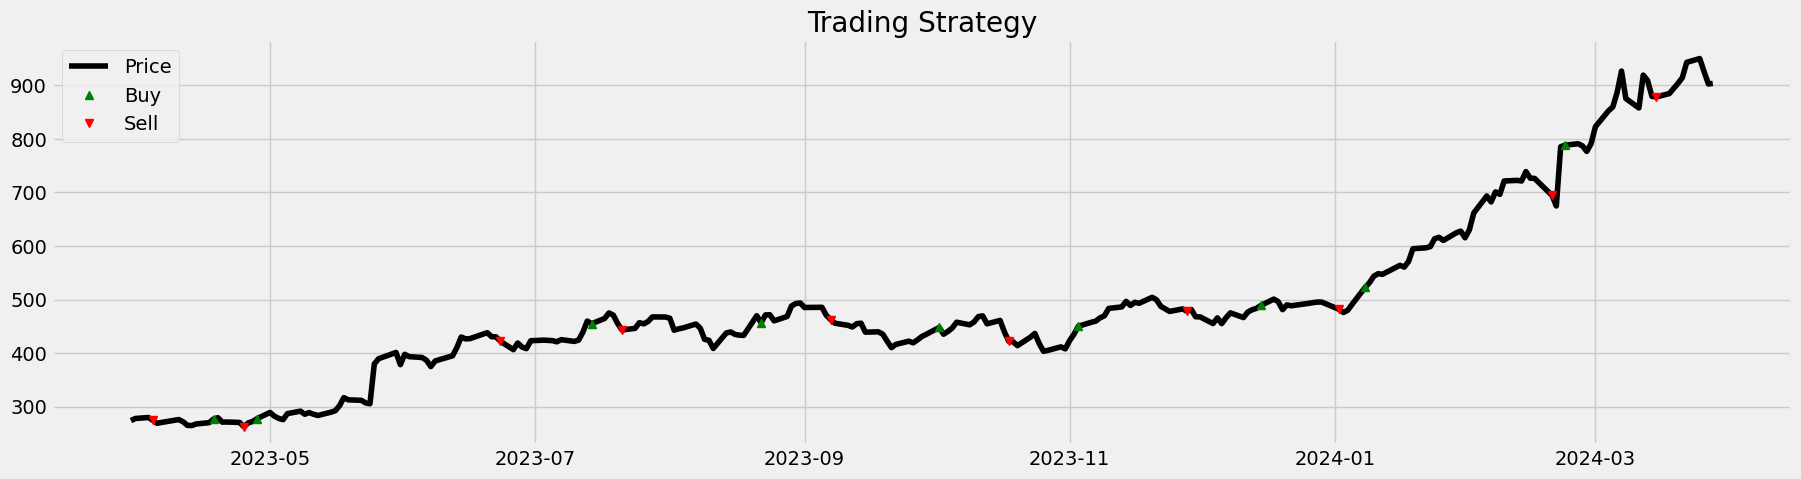

In [11]:
plt.figure(figsize=(20, 5))

plt.title('Trading Strategy')

# Plot main price line
plt.plot(macd_df.index,macd_df['Real'], label='Price', color='black')

# Differentiate buy and sell signals with markers and colors
buy_signals = macd_df[macd_df['signal'] == 1].index
sell_signals = macd_df[macd_df['signal'] == -1].index

plt.plot(buy_signals, macd_df['Real'][buy_signals], marker='^', linestyle='', color='green', label='Buy')  # Green triangle for buy
plt.plot(sell_signals, macd_df['Real'][sell_signals], marker='v', linestyle='', color='red', label='Sell')  # Red triangle for sell

plt.legend()
plt.show()

In [12]:
inital_capital = 500,000
position = [0]
cash_flow = [500000]
close_price = ewma_df['Real'].values
signals = ewma_df['signal'].values
holding_values = [500000]

for i in range(0, len(close_price)-1):
    current_position = position[-1]
    current_cash_flow = cash_flow[-1]
    current_price = close_price[i]
    current_signal = signals[i]
    current_holding_value = holding_values[-1]
    
    if current_position > 0:
        current_holding_value = current_position * current_price
    
    # if the signal is 1, it means the price is going up, so we buy
    if current_signal == 1:
        if current_position < 0:
            sell_stock = abs(current_position)
            sold_money = sell_stock * current_price
            current_cash_flow += sold_money
            current_position = 0
        if current_position == 0:
            buy_stock = current_cash_flow / current_price
            buy_money = buy_stock * current_price
            current_cash_flow -= buy_money
            current_position = buy_stock
            
    # if the signal is -1, it means the price is going down, so we sell
    elif current_signal == -1:
        if current_position > 0:
            sell_stock = abs(current_position)
            sold_money = sell_stock * current_price
            current_cash_flow += sold_money
            current_position = 0
            
    current_holding_value = current_position * current_price + current_cash_flow
    position.append(current_position)
    cash_flow.append(current_cash_flow)
    holding_values.append(current_holding_value)
    
current_position = position[-1]
current_cash_flow = cash_flow[-1]

if current_position > 0:
    sell_stock = abs(current_position)
    sold_money = sell_stock * ewma_df['Real'].iloc[-1]
    current_cash_flow += sold_money
    current_position = 0
    
current_holding_value = current_position * current_price + current_cash_flow

holding_values.append(current_holding_value)
position.append(0)
cash_flow.append(current_cash_flow)
print(f'Final Position: {current_position}')
print(f'Final Cash Flow: {current_cash_flow}')
print(f'Final Portfolio Value: {current_cash_flow + (current_position * ewma_df["Real"].iloc[-1])}')

Final Position: 0
Final Cash Flow: 1562711.828515147
Final Portfolio Value: 1562711.828515147


In [13]:
df_ewma = pd.DataFrame({"position": position, "cash_flow": cash_flow, "holding_value": holding_values})
df_ewma = df_ewma[1:]
df_ewma.index = macd_df.index
df_ewma["excess_return"] = df_ewma["holding_value"].pct_change()
df_ewma.fillna(0, inplace=True)

In [14]:
inital_capital = 500,000
position = [0]
cash_flow = [500000]
close_price = macd_df['Real'].values
signals = macd_df['signal'].values
holding_values = [500000]

for i in range(0, len(close_price)-1):
    current_position = position[-1]
    current_cash_flow = cash_flow[-1]
    current_price = close_price[i]
    current_signal = signals[i]
    current_holding_value = holding_values[-1]
    
    if current_position > 0:
        current_holding_value = current_position * current_price
    
    # if the signal is 1, it means the price is going up, so we buy
    if current_signal == 1:
        if current_position < 0:
            sell_stock = abs(current_position)
            sold_money = sell_stock * current_price
            current_cash_flow += sold_money
            current_position = 0
        if current_position == 0:
            buy_stock = current_cash_flow / current_price
            buy_money = buy_stock * current_price
            current_cash_flow -= buy_money
            current_position = buy_stock
            
    # if the signal is -1, it means the price is going down, so we sell
    elif current_signal == -1:
        if current_position > 0:
            sell_stock = abs(current_position)
            sold_money = sell_stock * current_price
            current_cash_flow += sold_money
            current_position = 0
            
    current_holding_value = current_position * current_price + current_cash_flow
    position.append(current_position)
    cash_flow.append(current_cash_flow)
    holding_values.append(current_holding_value)
    
current_position = position[-1]
current_cash_flow = cash_flow[-1]

if current_position > 0:
    sell_stock = abs(current_position)
    sold_money = sell_stock * ewma_df['Real'].iloc[-1]
    current_cash_flow += sold_money
    current_position = 0
    
current_holding_value = current_position * current_price + current_cash_flow

holding_values.append(current_holding_value)
position.append(0)
cash_flow.append(current_cash_flow)
print(f'Final Position: {current_position}')
print(f'Final Cash Flow: {current_cash_flow}')
print(f'Final Portfolio Value: {current_cash_flow + (current_position * ewma_df["Real"].iloc[-1])}')

Final Position: 0
Final Cash Flow: 1039999.6186396726
Final Portfolio Value: 1039999.6186396726


In [15]:
df_macd = pd.DataFrame({"position": position, "cash_flow": cash_flow, "holding_value": holding_values})
df_macd  = df_macd[1:]
df_macd.index = macd_df.index 
df_macd["excess_return"] = df_macd["holding_value"].pct_change()
df_macd.fillna(0, inplace=True)

In [16]:
def algorithmic_trading(data, target_name):
    position = [0]
    cash_flow = [500000]
    close_price_list= data['Real'].values
    tomrrow_price_list = data[target_name].values
    holding_values = []
    
    for i in range(0, len(close_price)):
        tomorrow_price = tomrrow_price_list[i]
        current_position = position[-1]
        current_cash_flow = cash_flow[-1]
        current_price = close_price_list[i]
        
        if current_position > 0:
            current_holding_value = current_position * current_price
        
        if current_price < tomorrow_price:
            if current_position < 0:
                sell_stock = abs(current_position)
                sold_money = sell_stock * current_price
                current_cash_flow += sold_money
                current_position = 0
            if current_position == 0:
                buy_stock = current_cash_flow / current_price
                buy_money = buy_stock * current_price
                current_cash_flow -= buy_money
                current_position = buy_stock
                
        elif current_price > tomorrow_price:
            if current_position > 0:
                sell_stock = abs(current_position)
                sold_money = sell_stock * current_price
                current_cash_flow += sold_money
                current_position = 0
        current_holding_value = current_position * current_price + current_cash_flow
         
        position.append(current_position)
        cash_flow.append(current_cash_flow)
        holding_values.append(current_holding_value)
       
    current_position = position[-1]
    current_cash_flow = cash_flow[-1]
    if current_position > 0:
        sell_stock = abs(current_position)
        sold_money = sell_stock * current_price
        current_cash_flow += sold_money
        current_position = 0
    holding_values.append(current_position * current_price + current_cash_flow)
    return position, cash_flow, holding_values

def get_trading_data(data, target_name):
    position, cash_flow, holding_values = algorithmic_trading(data, target_name)
    df = pd.DataFrame({'Position': position, 'Cash Flow': cash_flow, 'Holding Value': holding_values})
    df["excess_return"] = df['Holding Value'].pct_change()
    df.loc[0, 'excess_return'] = 0
    # remove the first row
    df = df[1:]
    df.index = data['Date']
    return df
    
transformer_trading_df = get_trading_data(trading_data, 'Predicted_Transformer')
arima_trading_df = get_trading_data(trading_data, 'Predicted_ARIMA')
null_trading_df = get_trading_data(trading_data, 'Predicted_Null')
lstm_trading_df = get_trading_data(trading_data, 'Predicted_LSTM')

In [17]:
print('Transformer Model')
print(transformer_trading_df['Holding Value'].iloc[-1])
print('ARIMA Model')
print(arima_trading_df['Holding Value'].iloc[-1])
print('Null Model')
print(null_trading_df['Holding Value'].iloc[-1])
print('LSTM Model')
print(lstm_trading_df['Holding Value'].iloc[-1])
print('EWMA Model')
print(df_ewma['holding_value'].iloc[-1])
print('MACD Model')
print(df_macd['holding_value'].iloc[-1])

Transformer Model
1649855.824592359
ARIMA Model
889108.122102235
Null Model
856650.5410211735
LSTM Model
645281.6268549713
EWMA Model
1562711.828515147
MACD Model
1039999.6186396726


In [18]:
def sharp_ratio(data):
    return (data['excess_return'].mean()*252) / (data['excess_return'].std()* np.sqrt(252))

def sortino_ratio(data):
    result = (data['excess_return'].mean()*252) / (data[data['excess_return'] < 0.00003]['excess_return'].std() * np.sqrt(252))
    if result == np.inf:
        return 0
    return result

print('Transformer Sharp Ratio:', sharp_ratio(transformer_trading_df))
print('ARIMA Sharp Ratio:', sharp_ratio(arima_trading_df))
print('Null Sharp Ratio:', sharp_ratio(null_trading_df))
print('LSTM Sharp Ratio:', sharp_ratio(lstm_trading_df))
print("EWMA Sharp Ratio:", sharp_ratio(df_ewma))
print("MACD Sharp Ratio:", sharp_ratio(df_macd))

print('Transformer Sortino Ratio:', sortino_ratio(transformer_trading_df))
print('ARIMA Sortino Ratio:', sortino_ratio(arima_trading_df))
print('Null Sortino Ratio:', sortino_ratio(null_trading_df))
print('LSTM Sortino Ratio:', sortino_ratio(lstm_trading_df))
print("EWMA Sortino Ratio:", sortino_ratio(df_ewma))
print("MACD Sortino Ratio:", sortino_ratio(df_macd))

Transformer Sharp Ratio: 2.7668095194713147
ARIMA Sharp Ratio: 1.6916889804206716
Null Sharp Ratio: 1.5642987318917412
LSTM Sharp Ratio: 1.055100999419929
EWMA Sharp Ratio: 2.687990976323806
MACD Sharp Ratio: 2.146440123054437
Transformer Sortino Ratio: 6.154089837495942
ARIMA Sortino Ratio: 4.1520535514574055
Null Sortino Ratio: 3.62528810656872
LSTM Sortino Ratio: 1.8274351774278137
EWMA Sortino Ratio: 5.626420258149785
MACD Sortino Ratio: 4.368592681262405


In [19]:
transformer_trading_df

,Position,Cash Flow,Holding Value,excess_return
Date,,,,
2023-03-30,1825.950494,0.0,5.071942e+05,0.014388
2023-03-31,1825.950494,0.0,5.106270e+05,0.006768
2023-04-03,1825.950494,0.0,5.012782e+05,-0.018309
2023-04-04,1825.950494,0.0,4.908337e+05,-0.020836
2023-04-05,1825.950494,0.0,4.936822e+05,0.005803
...,...,...,...,...
2024-03-22,1825.950494,0.0,1.734690e+06,0.007562
2024-03-25,1825.950494,0.0,1.690118e+06,-0.025694
2024-03-26,1825.950494,0.0,1.647920e+06,-0.024967


In [20]:
# show plot of Sharp Ratio and Sortino Ratio
# with number on the top of the bar
sharp_ratio_list = [sharp_ratio(transformer_trading_df), sharp_ratio(arima_trading_df), sharp_ratio(null_trading_df), sharp_ratio(lstm_trading_df), sharp_ratio(df_ewma), sharp_ratio(df_macd)]
sortino_ratio_list = [sortino_ratio(transformer_trading_df), sortino_ratio(arima_trading_df), sortino_ratio(null_trading_df), sortino_ratio(lstm_trading_df), sortino_ratio(df_ewma), sortino_ratio(df_macd)]
holding_value_list = [transformer_trading_df['Holding Value'].iloc[-1], arima_trading_df['Holding Value'].iloc[-1], null_trading_df['Holding Value'].iloc[-1], lstm_trading_df['Holding Value'].iloc[-1], df_ewma['holding_value'].iloc[-1], df_macd['holding_value'].iloc[-1]]
excess_return_list = [transformer_trading_df['excess_return'].mean()*252, arima_trading_df['excess_return'].mean()*252, null_trading_df['excess_return'].mean()*252, lstm_trading_df['excess_return'].mean()*252, df_ewma['excess_return'].mean()*252, df_macd['excess_return'].mean()*252]

# keep the 4 significant digits
sharp_ratio_list = [round(x, 4) for x in sharp_ratio_list]
sortino_ratio_list = [round(x, 4) for x in sortino_ratio_list]
holding_value_list = [round(x, 2) for x in holding_value_list]
excess_return_list = [round(x, 4) for x in excess_return_list]

fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Bar(x=['Transformer', 'ARIMA', 'Naive Prediction', 'LSTM', 'EWMA', 'MACD'], y=sharp_ratio_list, text=sharp_ratio_list, textposition='auto', name='Sharp Ratio'), row=1, col=1)
fig.add_trace(go.Bar(x=['Transformer', 'ARIMA', 'Naive Prediction', 'LSTM', 'EWMA', 'MACD'], y=sortino_ratio_list, text=sortino_ratio_list, textposition='auto', name='Sortino Ratio'), row=2, col=1)
fig.add_trace(go.Bar(x=['Transformer', 'ARIMA', 'Naive Prediction', 'LSTM', 'EWMA', 'MACD'], y=holding_value_list, text=holding_value_list, textposition='auto', name='Holding Value ($)'), row=3, col=1)
fig.add_trace(go.Bar(x=['Transformer', 'ARIMA', 'Naive Prediction', 'LSTM', 'EWMA', 'MACD'], y=excess_return_list, text=excess_return_list, textposition='auto', name='Annualise Excess Return'), row=4, col=1)

fig.show()

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# we copied the result from the models result for simplicity
rmse_tranformer_validation = 1019420176744461
rmse_transfomer_test = 0.17034576833248138

rmse_lstm_validation = 54.63269147220589
rmse_lstm_test =  224.92665923294703

rmse_arima_test = 26.56927848796555
rmse_null_test = 15.254295942158924

In [22]:
# plot the hoding value of the models
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=transformer_trading_df.index, y=transformer_trading_df['Holding Value'], name='Transformer'), row=2, col=1)
fig.add_trace(go.Scatter(x=lstm_trading_df.index, y=lstm_trading_df['Holding Value'], name='LSTM'), row=2, col=1)
fig.add_trace(go.Scatter(x=arima_trading_df.index, y=arima_trading_df['Holding Value'], name='ARIMA'), row=2, col=1)
fig.add_trace(go.Scatter(x=null_trading_df.index, y=null_trading_df['Holding Value'], name='Naive Prediction'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_ewma.index, y=df_ewma['holding_value'], name='EWMA'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_macd.index, y=df_macd['holding_value'], name='MACD'), row=2, col=1)

fig.add_trace(go.Scatter(x=transformer_trading_df.index, y=trading_data['Real'], name='Close Price ($)'), row=1, col=1)

# y_axis
fig.update_yaxes(title_text="Close Price ($)", row=1, col=1)
fig.update_yaxes(title_text="Holding Value ($)", row=2, col=1)

fig.show()